# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация. 

### Общая информация
Дата выдачи: 29.10.2020

Мягкий дедлайн: 23:59MSK 10.11.2020 (за каждый день просрочки снимается 1 балл)

Жесткий дедлайн: 23:59MSK 13.11.2020

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-classification-Username.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-classification-IvanovIvan.ipynb).

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

**Оценка**: 

In [641]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# Часть 0. SVM, LR и калибровка вероятностей. 

Сгенерируем синтетические данные.

In [642]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)


__Задание 1.__ Обучение и применение метода опорных векторов и логистической регрессии.

__(1 балл)__

Обучите метод опорных векторов. На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`). Подберите параметр регуляризации `C` (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей). __Здесь и далее, если не сказано иначе, подбирайте оптимальные гиперпараметры с точки зрения AUC-PR.__

In [647]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3 )

In [648]:
import numpy as np
from sklearn import metrics
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

# https://sinyi-chou.github.io/python-sklearn-precision-recall/



def find_best_c(X_train, y_train, X_test, y_test, learn_model):
    
    auc_pr_list = []

    for c in tqdm(np.linspace(0.001, 1, 10)):
        model = learn_model(max_iter=100000, C=c).fit(X_train, y_train)
        pred = model.predict(X_test)
        precision, recall, thresholds = precision_recall_curve(y_test, pred)
        auc_precision_recall = auc(recall, precision)
        auc_pr_list.append(auc_precision_recall)

    return np.linspace(0.01, 1, 10)[np.argmax(auc_pr_list)]
        

In [645]:
c_best_svc = find_best_c(X_train, y_train, X_valid, y_valid, LinearSVC)

100%|███████████████████████████████████████████| 10/10 [00:04<00:00,  2.22it/s]


In [646]:
c_best_svc

0.01

На тестовой части постройте ROC и PR кривые, а также посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков. Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора (который на каждом объекте выдаёт один из двух классов с равными вероятностями).

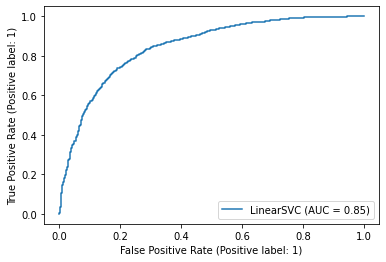

In [293]:
import matplotlib.pyplot as plt
from sklearn import datasets, metrics, model_selection, svm

svc = LinearSVC(max_iter=100000, C=c_best_svc).fit(X_train, y_train)
metrics.plot_roc_curve(svc, X_test, y_test) 

plt.show() 

In [660]:
precision, recall, thresholds = precision_recall_curve(y_test, svc.predict(X_test))
auc_precision_recall = auc(recall, precision)
print('AUC_PR:')
np.round(auc_precision_recall, 5)

AUC_PR:


0.83264

In [659]:
print('AUC_ROC:')
metrics.roc_auc_score(y_test, svc.predict(X_test))

AUC_ROC:


0.7733419981499846

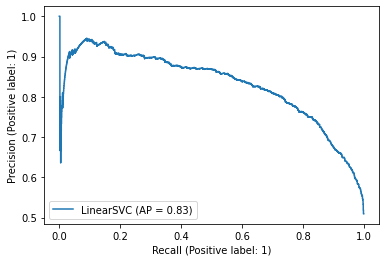

In [661]:
metrics.plot_precision_recall_curve(svc, X_test, y_test)

In [653]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="uniform")
dummy_clf.fit(X_train, y_train)

DummyClassifier(strategy='uniform')

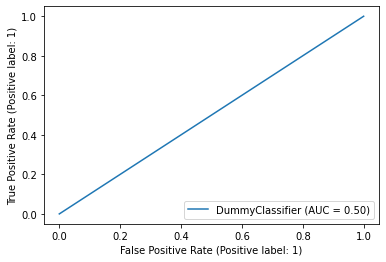

In [654]:
metrics.plot_roc_curve(dummy_clf, X_test, y_test) 

plt.show()

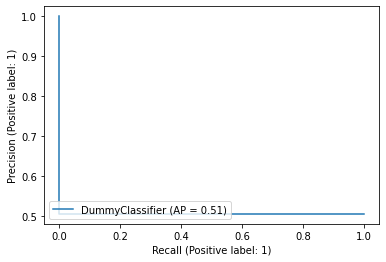

In [655]:
metrics.plot_precision_recall_curve(dummy_clf, X_test, y_test) # рандом победил!

In [662]:
precision, recall, thresholds = precision_recall_curve(y_test, dummy_clf.predict(X_test))
auc_precision_recall = auc(recall, precision)
print('AUC-PR:')
np.round(auc_precision_recall, 5)

AUC-PR:


0.62612

А теперь проделайте все то же самое для логистической регрессии (LR) — обучение, подбор параметра регуляризации (используйте L2-регуляризацию), вычисление всех метрик и построение кривых. Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 34.46it/s]


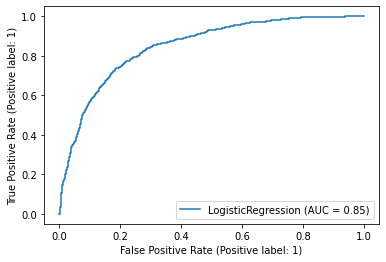

In [657]:
import matplotlib.pyplot as plt
from sklearn import datasets, metrics, model_selection, svm
import numpy as np
from sklearn import metrics
from sklearn.svm import LinearSVC
from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc
# https://sinyi-chou.github.io/python-sklearn-precision-recall/

c_best_lr = find_best_c(X_train, y_train, X_valid, y_valid, LogisticRegression)

lr = LogisticRegression(max_iter=100000, C=c_best_lr).fit(X_train, y_train)
metrics.plot_roc_curve(lr, X_test, y_test) 

plt.show()

In [663]:
precision, recall, thresholds = precision_recall_curve(y_test, lr.predict(X_test))
auc_precision_recall = auc(recall, precision)
print('AUC_PR:')
np.round(auc_precision_recall, 5)

AUC_PR:


0.8343

In [664]:
print('AUC_ROC:')
metrics.roc_auc_score(y_test, lr.predict(X_test))

AUC_ROC:


0.7753951507549193

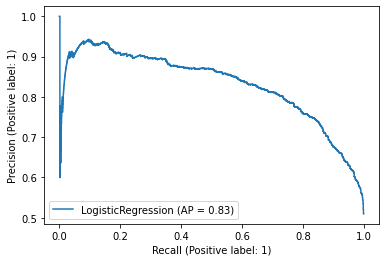

In [665]:
metrics.plot_precision_recall_curve(lr, X_test, y_test)

In [ ]:
# результаты очень похожи

В названии метода опорных векторов присутствуют некоторые "опорные векторы". Сгенерируйте синтетические данные с помощью `make_classification` с 2 признаками, обучите на нём метод опорных векторов. Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`). В этот раз, если необходимо, вместо `LinearSVC` воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах.

In [13]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=10000,
                              n_features=2,
                              n_informative=2, 
                              n_redundant=0,
                              n_repeated=0, 
                              n_classes=2, 
                              random_state = 42)

In [14]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y, test_size=0.3, random_state=42)

In [15]:
# https://sinyi-chou.github.io/python-sklearn-precision-recall/
c_best = find_best_c(X_train_, y_train_, X_test_, y_test_, LinearSVC)

svc = SVC(kernel='linear', max_iter=100000, C=c_best).fit(X_train_, y_train_)

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.05it/s]


No handles with labels found to put in legend.


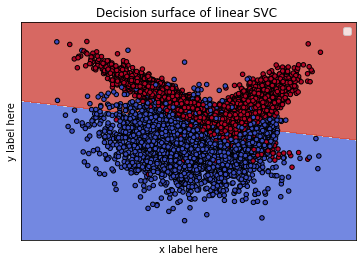

In [16]:
# https://stackoverflow.com/questions/51495819/how-to-plot-svm-decision-boundary-in-sklearn-python
# https://scikit-learn.org/stable/auto_examples/svm/plot_linearsvc_support_vectors.html

def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

svc = SVC(kernel='linear', max_iter=100000, C=c_best).fit(X_train_, y_train_)

fig, ax = plt.subplots()
# title for the plots
title = ('Decision surface of linear SVC ')
# Set-up grid for plotting.
X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, svc, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')

ax.set_ylabel('y label here')
ax.set_xlabel('x label here')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
ax.legend()
plt.show()

In [ ]:
# plt.figure(figsize=(10, 5))
# for i, C in enumerate([1, 100]):
#     # "hinge" is the standard SVM loss
#     clf = LinearSVC(C=C, loss="hinge", random_state=42).fit(X, y)
#     # obtain the support vectors through the decision function
#     decision_function = clf.decision_function(X)
#     # we can also calculate the decision function manually
#     # decision_function = np.dot(X, clf.coef_[0]) + clf.intercept_[0]
#     # The support vectors are the samples that lie within the margin
#     # boundaries, whose size is conventionally constrained to 1
#     support_vector_indices = np.where(np.abs(decision_function) <= 1 + 1e-15)[0]
#     support_vectors = X[support_vector_indices]

#     plt.subplot(1, 2, i + 1)
#     plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)
#     ax = plt.gca()
#     xlim = ax.get_xlim()
#     ylim = ax.get_ylim()
#     xx, yy = np.meshgrid(
#         np.linspace(xlim[0], xlim[1], 50), np.linspace(ylim[0], ylim[1], 50)
#     )
#     Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
#     Z = Z.reshape(xx.shape)
#     plt.contour(
#         xx,
#         yy,
#         Z,
#         colors="k",
#         levels=[-1, 0, 1],
#         alpha=0.5,
#         linestyles=["--", "-", "--"],
#     )
#     plt.scatter(
#         support_vectors[:, 0],
#         support_vectors[:, 1],
#         s=100,
#         linewidth=1,
#         facecolors="none",
#         edgecolors="k",
#     )
#     plt.title("C=" + str(C))
# plt.tight_layout()
# plt.show()

In [17]:
import matplotlib.pyplot as plt
from sklearn import datasets, metrics, model_selection, svm

c_best = find_best_c(X_train_, y_train_, X_test_, y_test_, LogisticRegression)

lr = LogisticRegression(max_iter=100000, C=c_best).fit(X_train, y_train)

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 22.14it/s]


В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты. Вам может помочь функция `plt.pcolor`.

In [18]:
import seaborn as sns

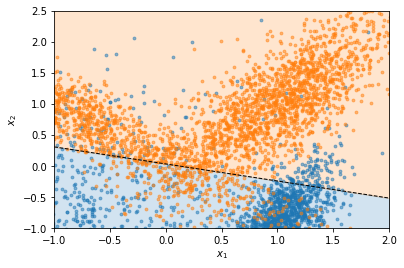

In [19]:
# https://scipython.com/blog/plotting-the-decision-boundary-of-a-logistic-regression-model/

lr = LogisticRegression(max_iter=100000, C=c_best)
lr.fit(X_train_, y_train_)

# Retrieve the model parameters.
b = lr.intercept_[0]
w1, w2 = lr.coef_.T
# Calculate the intercept and gradient of the decision boundary.
c = -b/w2
m = -w1/w2

# Plot the data and the classification with the decision boundary.
xmin, xmax = -1, 2
ymin, ymax = -1, 2.5
xd = np.array([xmin, xmax])
yd = m*xd + c
plt.plot(xd, yd, 'k', lw=1, ls='--')
plt.fill_between(xd, yd, ymin, color='tab:blue', alpha=0.2)
plt.fill_between(xd, yd, ymax, color='tab:orange', alpha=0.2)

plt.scatter(*X_train_[y_train_==0].T, s=8, alpha=0.5)
plt.scatter(*X_train_[y_train_==1].T, s=8, alpha=0.5)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.ylabel(r'$x_2$')
plt.xlabel(r'$x_1$')

plt.show()

__Задание 2.__ Калибровка вероятностей.

__(1 балл)__

Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых. 

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины. Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной. Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [667]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2) # поменяла - на + (центры отрезков)
        bin_real_ratios.append(np.sum(y_test[(preds >= l) & (preds < r)] == 1) 
                               / len(y_test[(preds >= l) & (preds < r)])) # доли единичных ответов
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$). Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`). Чем они различаются? Чем вы можете объяснить это?

In [668]:
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [669]:
svc = SVC(kernel='linear', max_iter=100000, C=c_best_svc).fit(X_train, y_train)
svc_pred = svc.decision_function(X_test)

# переведем предсказание как в семинаре
svc_pred = (svc_pred - svc_pred.min()) / (svc_pred.max() - svc_pred.min())

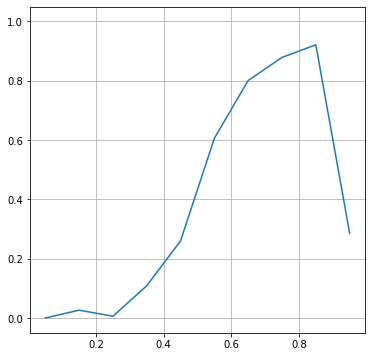

In [670]:
plot_calibration_curve(y_test, svc_pred) # нуууу, почти диагональное

<AxesSubplot:ylabel='Count'>

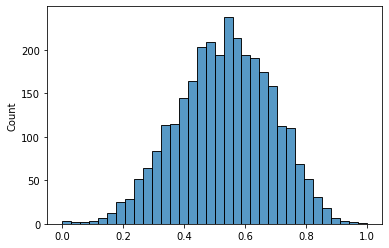

In [671]:
sns.histplot(svc_pred)

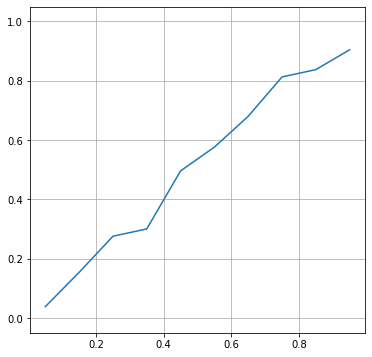

In [26]:
lr = LogisticRegression(max_iter=100000, C=c_best).fit(X_train, y_train)
lr_pred = lr.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, lr_pred) # оооОООоО!!!!

<AxesSubplot:ylabel='Count'>

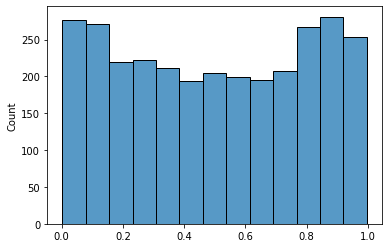

In [27]:
sns.histplot(lr_pred)

In [ ]:
# мы видим, что у lr вероятсноти распределены примерно одинаково
# у svc же они распределены нормально
# вероятно, это происходит из-за распределяющей полосы svm, которая влияет на уверенности модели

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

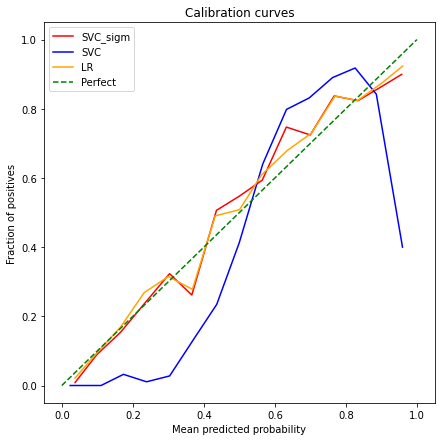

In [672]:
# код из шестого семинара
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

plt.figure(figsize=(7, 7))

sigmoid_svc = CalibratedClassifierCV(svc, cv=3, method='sigmoid').fit(X_train, y_train)
sigmoid_svc_pred = sigmoid_svc.predict_proba(X_test)[:, 1]

svc_true_prob, svc_pred_prob = calibration_curve(y_test, svc_pred, n_bins=15)
sigm_svc_true_prob, sigm_svc_pred_prob = calibration_curve(y_test, sigmoid_svc_pred, n_bins=15)
lr_true_prob, lr_pred_prob = calibration_curve(y_test, lr_pred, n_bins=15)

plt.plot(sigm_svc_pred_prob, sigm_svc_true_prob, label='SVC_sigm', color='red') # мы видим, что стало лучше!!
plt.plot(svc_pred_prob, svc_true_prob, label='SVC', color='blue')
plt.plot(lr_pred_prob, lr_true_prob, label='LR', color='orange')
plt.plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')

plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curves')
plt.legend()
plt.show() # да, стало значительнос лучше!

In [29]:
# воспользуемся определением из семинара

__Бонусное задание (0.5 балла).__ Реализуйте свою функцию для калибровки вероятностей. Опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [33]:
sigm_svc_true_prob,sigm_svc_pred_prob

(array([0.00858369, 0.08189655, 0.16336634, 0.235     , 0.31472081,
        0.26011561, 0.52469136, 0.53333333, 0.59893048, 0.75294118,
        0.72395833, 0.83561644, 0.82553191, 0.86821705, 0.89142857]),
 array([0.03792749, 0.09835124, 0.16476404, 0.23288661, 0.30311015,
        0.36556707, 0.43666038, 0.50158776, 0.56427544, 0.63068835,
        0.69917531, 0.76721351, 0.83369974, 0.90142586, 0.9571743 ]))

**Калибровка Платта**

Допустим, у нас есть обученный класификатор $b(x)$, который выдает уверенность (скор) в том, что $x$ относится к положительному классу. Метод приближает вероятность положительного класса с помощью сигмоидной функции:

$$
p\big(y = +1 \big| b(x)\big) = \frac{1}{1 + \exp (A \cdot b(x) + C)}
$$

Здесь обучаемыми параметрами являются $A, C \in \mathbb{R}$, их подбирают с помощью метода максимального правдоподобия (точно так же, как в логистической регрессии). Сделать это можно по кросс-валидации или на отложенной выборке. 

# Часть 1. Работа с переменными.

В этой части мы научимся обрабатывать категориальные переменные, так как закодировать их в виде чисел недостаточно (это задаёт некоторый порядок, которого на категориальных переменных может и не быть). Существует два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

__Подготовка данных.__

Загрузим данные [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге, объектом в нем является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит), целевой переменной - ответ клиента (согласился ли он открыть депозит?). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.

In [36]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')


--2021-11-09 18:12:29--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Распознаётся archive.ics.uci.edu (archive.ics.uci.edu)… 128.195.10.252
Подключение к archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 444572 (434K) [application/x-httpd-php]
Сохранение в: «bank-additional.zip.14»

bank-additional.zip 100%[===================>] 434,15K   459KB/s    за 0,9s    

2021-11-09 18:12:31 (459 KB/s) - «bank-additional.zip.14» сохранён [444572/444572]

Archive:  bank-additional.zip
replace bank-additional/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [37]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [38]:
df.y.value_counts() # норм такой дисбаланс

no     36548
yes     4640
Name: y, dtype: int64

__Задание 3 (0.5 балла).__ Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`. Один из столбцов в данных не несет информации для решения задачи — какой? Отбросьте его. 



In [39]:
#Из описания данных:
# 1 - duration: last contact duration, in seconds (numeric). 
#     Important note: this attribute highly affects the output target (e.g., 
#     if duration=0 then y='no'). Yet, the duration is not known before a call is performed. 
#     Also, after the end of the call y is obviously known. Thus, this input should only be included 
#     for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

# уберем этот признак

df = df.drop(columns=['duration'])

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c `AUC-PR`) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели (с учетом кодирования признаков).

__Вопрос__: почему в данном задании мы выбрали метрикой именно `AUC-PR`, а не, к примеру, `AUC-ROC`?

__Ваш ответ__:

In [40]:
# AUC-PR точнее работает на несбалансированных выборках (см 5 лекцию)

In [41]:
df.nunique()

age                78
job                12
marital             4
education           8
default             3
housing             3
loan                3
contact             2
month              10
day_of_week         5
campaign           42
pdays              27
previous            8
poutcome            3
emp.var.rate       10
cons.price.idx     26
cons.conf.idx      26
euribor3m         316
nr.employed        11
y                   2
dtype: int64

In [42]:
# категориальные признаки (тоже взяла из описания): 
# job, marital, education, default, housing, loan, contact, month, day_of_week, poutcome


In [43]:
from sklearn.preprocessing import OrdinalEncoder 
enc = OrdinalEncoder()

categorical = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']

df[categorical] = enc.fit_transform(df[categorical])

In [44]:
x = df[df.columns[:-1]]
y = df[df.columns[-1]]

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score

X_train, X_test, y_train, y_test = train_test_split(x,y, 
                                                  train_size=0.75, 
                                                  random_state=777, 
                                                  stratify=y)

In [46]:
lr = LogisticRegression(max_iter=100000)
lr.fit(X_train, y_train)
y_score = lr.predict(X_test)

In [47]:
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
auc_precision_recall = auc(recall, precision)
auc_precision_recall

0.501124576890935

__Задание 4 (0.5 балла).__ Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.



In [48]:
df[categorical] = enc.inverse_transform(df[categorical])


In [49]:
from sklearn.preprocessing import OneHotEncoder


ohe = OneHotEncoder()

x = df[df.columns[:-1]]
y = df[df.columns[-1]]

categorical_ = categorical[:-1]

x = ohe.fit_transform(x[categorical_])

In [50]:
from sklearn.preprocessing import LabelEncoder
lab = LabelEncoder()
y = lab.fit_transform(y)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(x,y, 
                                                  train_size=0.75, 
                                                  random_state=777, 
                                                  stratify=y)

c_best = find_best_c(X_train, y_train, X_test, y_test, LogisticRegression)

lr = LogisticRegression(max_iter=100000, C=c_best)

100%|███████████████████████████████████████████| 10/10 [00:06<00:00,  1.52it/s]


In [52]:
%%time
lr.fit(X_train, y_train)

y_score = lr.predict(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
auc_precision_recall = auc(recall, precision)
auc_precision_recall

CPU times: user 285 ms, sys: 5.34 ms, total: 290 ms
Wall time: 305 ms


0.48793188490577577

Как можно было заменить, one-hot-кодирование может сильно увеличивать количество признаков, что сказывается на памяти, особенно, если некоторый признак имеет большое количество значений. Эту проблему решает другой способ кодирования категориальных признаков — mean-target encoding (для простоты будем называть это счётчиками). Основная идея в том, что нам важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$

__Задание 5 (1 балл).__ Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве. Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков). Заметили ли вы что-то интересное?


__Бонус (1 балл)__: Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их. 


In [53]:
#получается, мы делим количество определенного значения признака при котором y=1 на количество значения этого признака

In [706]:
df_ = df.copy()

In [707]:
%%time
for feature in categorical_:
    unique = df_[feature].unique()
    
    for value in unique:
        
        value_with_one = df_[
            (df_[feature] == value) &
            (df_['y'] == 'yes')]['job'].count()       
        
        all_value_count = df_[
            df_[feature] == value]['job'].count()
        
        df_.loc[df_[feature] == value, feature] = value_with_one / all_value_count
        

CPU times: user 12.2 s, sys: 84.4 ms, total: 12.3 s
Wall time: 12.9 s


In [708]:
x = df_[df_.columns[:-1]]
y = df_[df_.columns[-1]]

In [709]:
lab = LabelEncoder()
y = lab.fit_transform(y)

In [710]:
X_train, X_test, y_train, y_test = train_test_split(x,y, 
                                                  train_size=0.75, 
                                                  random_state=777, 
                                                  stratify=y)


lr = LogisticRegression(max_iter=100000)
lr.fit(X_train, y_train)
y_score = lr.predict(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
auc_precision_recall = auc(recall, precision)
auc_precision_recall

0.5561082211115029

Отметим, что такие признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к переобучению, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его целевая метка не использовалась. Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки. 

__Задание 6.__ Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям (постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков). Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.

__(0.5 балла)__

In [711]:
for feature in categorical_:
    noise = np.random.normal(0, 10, df_.shape[0])
    df_[feature] = df_[feature] + noise

In [712]:
x = df_[df_.columns[:-1]]

In [713]:
X_train, X_test, y_train, y_test = train_test_split(x,y, 
                                                  train_size=0.75, 
                                                  random_state=777, 
                                                  stratify=y)

lr = LogisticRegression(max_iter=100000) 
lr.fit(X_train, y_train)
y_score = lr.predict(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
auc_precision_recall = auc(recall, precision)
auc_precision_recall # шум действительно борется с переобучением!

0.5582717758108648

__(Бонусная часть, 0.5 балла)__ Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум). 



А теперь ответьте на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (например, можно использовать 10 или подобрать для каждого признака свой). Основная идея в том, что мы "разбавляем" среднее значение по некоторой категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке. 

Однако для сглаживания вместо среднего значения целевой переменной можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!


__Задание 7 (1 балл).__ Добавьте сглаживание, описанное выше и повторите эксперименты.

In [714]:
df1 = df.copy()

In [715]:
global_mean = df1['y'].value_counts()['yes'] / len(df1['y'])
c = 10

In [716]:
%%time
for feature in categorical_:
    unique = df1[feature].unique()
    
    for value in unique:
        
        value_with_one = df1[
            (df1[feature] == value) &
            (df1['y'] == 'yes')]['job'].count() + c * global_mean
        
        all_value_count = df1[
            df1[feature] == value]['job'].count() + c
        
        df1.loc[df1[feature] == value, feature] = value_with_one / all_value_count


CPU times: user 12.3 s, sys: 80.5 ms, total: 12.4 s
Wall time: 13.2 s


In [717]:
x = df1[df1.columns[:-1]]
y = df1['y']

lb = LabelEncoder()
y = lb.fit_transform(y)

In [718]:
X_train, X_test, y_train, y_test = train_test_split(x,y, 
                                                  train_size=0.75, 
                                                  random_state=777, 
                                                  stratify=y)


lr = LogisticRegression(max_iter=100000)
lr.fit(X_train, y_train)

y_score = lr.predict(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
auc_precision_recall = auc(recall, precision)
auc_precision_recall # пока шум выигрывает

0.5584465104124989

__Задание 8 (0.5 балла).__ В данных имеется признак "возраст клиента". Сейчас мы интерпретируем его как числовой, что в общем случае для линейной модели может быть неверной гипотезой. Тем не менее, у этого признака есть довольно много уникальных значений (сколько?), поэтому применять к нему one-hot кодирование может оказаться излишним. Попробуйте закодировать возраст с помощью счетчиков. Стало ли лучше?



In [719]:
unique = df['age'].unique()

for value in unique:

    value_with_one = df[
        (df['age'] == value) &
        (df['y'] == 'yes')]['job'].count() + c * global_mean

    all_value_count = df[
        df['age'] == value]['job'].count() + c

    df1.loc[df_['age'] == value, 'age'] = value_with_one / all_value_count

In [720]:
x = df1[df1.columns[:-1]]

In [721]:
X_train, X_test, y_train, y_test = train_test_split(x,y, 
                                                  train_size=0.75, 
                                                  random_state=777, 
                                                  stratify=y)


lr = LogisticRegression(max_iter=100000)
lr.fit(X_train, y_train)

y_score = lr.predict(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
auc_precision_recall = auc(recall, precision)
auc_precision_recall # стало хуже

0.555026443761822

In [722]:
for value in unique:

    value_with_one = df_[
        (df_[feature] == value) &
        (df_['y'] == 'yes')]['job'].count()       

    all_value_count = df_[
        df_[feature] == value]['job'].count()

    df_.loc[df_[feature] == value, feature] = value_with_one / all_value_count 


noise = np.random.normal(0, 10, df_.shape[0])
df_['age'] = df_['age'] + noise

/var/folders/5b/j4k5qtvx2j7b9nzkp2clls4c0000gp/T/ipykernel_50103/240578827.py:10: RuntimeWarning: invalid value encountered in long_scalars
  df_.loc[df_[feature] == value, feature] = value_with_one / all_value_count


In [723]:
x = df_[df_.columns[:-1]]

In [724]:
X_train, X_test, y_train, y_test = train_test_split(x,y, 
                                                  train_size=0.75, 
                                                  random_state=777, 
                                                  stratify=y)

lr = LogisticRegression(max_iter=100000) 
lr.fit(X_train, y_train)
y_score = lr.predict(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
auc_precision_recall = auc(recall, precision)
auc_precision_recall 

0.555026443761822

Можно пойти и в обратную сторону. У нас есть признаки "месяц и день недели" для звонка. Попробуйте интерпретировать их как числовые (месяц от 0 до 12, дни недели от 0 до 4). Стало ли лучше в этот раз?

In [725]:
lab = LabelEncoder()
df_['day_of_week'] = lab.fit_transform(df['day_of_week'])


In [726]:
lab = LabelEncoder()
df_['month'] = lab.fit_transform(df['month'])

In [727]:
x = df_[df_.columns[:-1]]

In [728]:
X_train, X_test, y_train, y_test = train_test_split(x,y, 
                                                  train_size=0.75, 
                                                  random_state=777, 
                                                  stratify=y)

In [729]:
lr = LogisticRegression(max_iter=100000)
lr.fit(X_train, y_train)

y_score = lr.predict(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
auc_precision_recall = auc(recall, precision)
auc_precision_recall 

0.5597825712927184

__Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).

Как вы должны были заметить, счётчики являются хорошей альтернативой one-hot-кодированию. Напишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ 
OHE - достаточно простой способ, но дает много признаков
Счетчики - более запарный вариант, там надо следить за утечкой данных, там много эксперементов, которые тоже требуют времени, но они могут дать кач-во получше, чем OHE (но не факт)

# Часть 2. Отбор признаков

In [730]:
numeric = ['age', 
           'campaign', 
           'pdays', 
           'previous', 
           'emp.var.rate', 
           'cons.price.idx', 
           'cons.conf.idx', 
           'euribor3m', 
           'nr.employed']

In [731]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

X = pd.get_dummies(df[categorical_])
X[numeric] = df[numeric]

y = (df.y == 'yes')
lb = LabelEncoder()
y = lb.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777, stratify=y)

In [732]:
X.shape # 62 признака

(41188, 62)

Как вы помните, в данных много категориальных признаков (сейчас давайте интерпретировать возраст как числовой). Давайте закодируем их с помощью one-hot кодирования. Исходные колонки с категориальными признаками можно удалить. Сколько признаков мы получили?

В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [733]:
lr = LogisticRegression(max_iter=100000)
lr.fit(X_train, y_train)

y_score = lr.predict(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
auc_precision_recall = auc(recall, precision)
auc_precision_recall

0.510598442653082

### Встроенные методы

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

__Задание 8 (0.5 балла).__ Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.

Изменилось ли качество? Как?



In [734]:
weights = lr.coef_[0]

In [735]:
number = np.sort(np.abs(weights))[-40]# 2.00523338e-02

In [736]:
weights = np.abs(weights)

In [737]:
weights_mask = weights >= number
len(X.columns[weights_mask])

40

In [738]:
X_new = X[X.columns[weights_mask]]

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=777, stratify=y)

In [739]:
lr = LogisticRegression(max_iter=100000)
lr.fit(X_train, y_train)

y_score = lr.predict(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
auc_precision_recall = auc(recall, precision)
auc_precision_recall

0.49945244152139134

А теперь давайте подумаем, что мы не учли. Мы предположили, что признаки вносят вклад равномерно, но не учли их масштаба. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки. 

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [740]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X[numeric] = ss.fit_transform(X[numeric])

In [741]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777, stratify=y)


lr = LogisticRegression(max_iter=100000)
lr.fit(X_train, y_train)


weights = lr.coef_[0]

number = np.sort(np.abs(weights))[-40]# 0.05978735905958852

weights = np.abs(weights)
weights_mask = weights >= number
len(X.columns[weights_mask])

40

In [742]:
X_new = X[X.columns[weights_mask]]

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=777, stratify=y)

lr = LogisticRegression(max_iter=100000)
lr.fit(X_train, y_train)

y_score = lr.predict(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
auc_precision_recall = auc(recall, precision)
auc_precision_recall

0.49194210630288226

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [743]:
len(numeric)

9

In [744]:
new_feature = X.columns[:-9]

In [745]:
ss = StandardScaler()
X[new_feature] = ss.fit_transform(X[new_feature])

In [746]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777, stratify=y)


lr = LogisticRegression(max_iter=100000)
lr.fit(X_train, y_train)


weights = lr.coef_[0]
number = np.sort(np.abs(weights))[-40]# 0.012913628932186972

weights = np.abs(weights)
weights_mask = weights >= number
len(X.columns[weights_mask])

40

In [747]:
X_new = X[X.columns[weights_mask]]

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=777, stratify=y)


lr = LogisticRegression(max_iter=100000)
lr.fit(X_train, y_train)

y_score = lr.predict(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
auc_precision_recall = auc(recall, precision)
auc_precision_recall # не поменялось

0.49194210630288226

### Методы фильтрации


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods. 

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

__Задание 9 (0.5 балла).__ Оставьте 40 признаков с наибольшим значением $t$ и замерьте качество. Не забудьте замерить скорость отбора признаков в этом случае.



In [749]:
X = pd.get_dummies(df[categorical_])
X[numeric] = df[numeric]

y = (df.y == 'yes')
lb = LabelEncoder()
y = lb.fit_transform(y)

X['y'] = y

In [750]:
t = []

for column in X.columns[:-1]:
    plus = X[f'{column}'].loc[np.where(y==1)]
    minus = X[f'{column}'].loc[np.where(y==0)]
    mu_plus = np.mean(plus)
    mu_min = np.mean(minus)
    delta_plus = np.std(plus) ** 2
    delta_min = np.std(minus) ** 2
    n_plus = len(plus)
    n_min = len(minus)
    
    t.append(np.abs(mu_plus - mu_min) / (np.sqrt((n_plus * delta_plus + n_min * delta_min) / (n_plus + n_min))))

In [751]:
number = np.sort(t)[-56]
weights_mask = weights >= number
len(X.columns[:-1][weights_mask]) # там дальше 10 признаков с одинаковым значением. Остановимся ан 39

39

In [752]:
X_new = X[X.columns[:-1][weights_mask]]

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=777, stratify=y)


lr = LogisticRegression(max_iter=100000)
lr.fit(X_train, y_train)

y_score = lr.predict(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
auc_precision_recall = auc(recall, precision)
auc_precision_recall 

0.5027519932935146

### Методы-обёртки

__Задание 10 (1 балл).__ 

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества).

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков? __МНОГО__

In [226]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

X = pd.get_dummies(df[categorical_])
X[numeric] = df[numeric]


#X = X.drop(columns=['duration', 'y'])
y = (df.y == 'yes')
lb = LabelEncoder()
y = lb.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=777, 
                                                    stratify=y)

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, 
                                                        y_train, 
                                                        test_size=0.3, 
                                                        random_state=777, 
                                                        stratify=y_train)

In [241]:
# не буду удалять, поскольку я это написала сама и ждала 20 минут пока оно обучится!!!

# def find_useless(X_train, X_test, y_train, y_test):
#     score_list = np.array([]) 
#     for column in X_train.columns:
#         lr = LogisticRegression(max_iter=100000)
#         lr.fit(X_train.drop(columns=[column]), y_train)

#         y_score = lr.predict(X_test.drop(columns=[column]))
#         precision, recall, thresholds = precision_recall_curve(y_test, y_score)
#         score_list = np.append(score_list, auc(recall, precision))
        
#     index_loser = np.argmin(score_list)
#     winners = np.delete(X_train.columns, index_loser)
#     return winners # возвращаем нужные колонки

In [243]:
# %%time
# useful_columns = X_train1.columns # это очень долго

# for i in tqdm(range(len(X.columns) - 40)):
#     useful_columns = find_useless(X_train1[useful_columns], 
#                                   X_test1[useful_columns], 
#                                   y_train1, 
#                                   y_test1) # Wall time: 19min 52s

In [ ]:
#https://towardsdatascience.com/feature-selection-for-machine-learning-in-python-wrapper-methods-2b5e27d2db31

In [ ]:
# Backward elimination

In [251]:
%%time
from sklearn.feature_selection import RFE

model = LogisticRegression(max_iter=100000)
#Define RFE 
rfe = RFE(model, 40)
#Use RFE to select the top 5 features 
fit = rfe.fit(X_train1, y_train1)

0it [00:09, ?it/s]


CPU times: user 37.6 s, sys: 2.13 s, total: 39.8 s
Wall time: 23.5 s


In [252]:
#Create a dataframe for the results 
df_RFE_results = []
for i in range(X_train1.shape[1]):
    df_RFE_results.append(
        {      
            'Feature_names': X_train1.columns[i],
            'Selected':  rfe.support_[i],
            'RFE_ranking':  rfe.ranking_[i],
        }
    )

df_RFE_results = pd.DataFrame(df_RFE_results)
df_RFE_results.index.name='Columns'
df_RFE_results

,Feature_names,Selected,RFE_ranking
Columns,,,
0,job_admin.,False,9
1,job_blue-collar,True,1
2,job_entrepreneur,False,11
3,job_housemaid,True,1
4,job_management,True,1
5,job_retired,True,1
6,job_self-employed,False,12
7,job_services,True,1
8,job_student,True,1


In [258]:
best_columns = list(df_RFE_results[df_RFE_results['Selected'] == True]['Feature_names'])

In [259]:
lr = LogisticRegression(max_iter=100000)
lr.fit(X_train[best_columns], y_train)

y_score = lr.predict(X_test[best_columns])
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
auc(recall, precision) 

0.5004502790563247

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [263]:
# !pip install mlxtend

In [267]:
# та же ссылка

In [ ]:
# Forward Selection 

In [264]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [266]:
%%time
sfs = SFS(LogisticRegression(max_iter=100000),
           k_features=40,
           forward=True,
           floating=False,
           scoring = 'r2',
           cv = 0)
#Use SFS to select the top 40 features 
sfs.fit(X_train1, y_train1)

#Create a dataframe for the SFS results 
df_SFS_results = pd.DataFrame(sfs.subsets_).transpose()
df_SFS_results #оставлю эту попытку, потому что она тоже долго работала

CPU times: user 14min 15s, sys: 58.7 s, total: 15min 14s
Wall time: 8min 57s


,feature_idx,cv_scores,avg_score,feature_names
1,"(52,)",[-0.026301261991317437],-0.026301,"(poutcome_success,)"
2,"(52, 57)",[-0.01805962041150555],-0.01806,"(poutcome_success, emp.var.rate)"
3,"(52, 55, 57)",[-0.015456996754722896],-0.015457,"(poutcome_success, pdays, emp.var.rate)"
4,"(41, 52, 55, 57)",[-0.012420602488476318],-0.012421,"(month_may, poutcome_success, pdays, emp.var.r..."
5,"(41, 50, 52, 55, 57)",[-0.00938420822222974],-0.009384,"(month_may, poutcome_failure, poutcome_success..."
6,"(5, 41, 50, 52, 55, 57)",[-0.008082896393838412],-0.008083,"(job_retired, month_may, poutcome_failure, pou..."
7,"(5, 17, 41, 50, 52, 55, 57)",[-0.007649125784374711],-0.007649,"(job_retired, education_basic.6y, month_may, p..."
8,"(0, 5, 17, 41, 50, 52, 55, 57)",[-0.007649125784374711],-0.007649,"(job_admin., job_retired, education_basic.6y, ..."
9,"(0, 5, 17, 40, 41, 50, 52, 55, 57)",[-0.007215355174910787],-0.007215,"(job_admin., job_retired, education_basic.6y, ..."
10,"(0, 1, 5, 17, 40, 41, 50, 52, 55, 57)",[-0.006781584565447085],-0.006782,"(job_admin., job_blue-collar, job_retired, edu..."


In [273]:
best_columns_1 = list(df_SFS_results['feature_names'][40])

In [274]:
lr = LogisticRegression(max_iter=100000)
lr.fit(X_train[best_columns_1], y_train)

y_score = lr.predict(X_test[best_columns_1])
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
auc(recall, precision) 

0.4869238510164684

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** К наилучшему качеству привели счетчики
ОГРОМНЫМ МИНУСОМ методов-оберток является количество времени, которое они сжирают, в данной задаче они еще и особо не помогли.

Встроенные методы оказались быстрыми, но не эффективынми,метод фильтрации тоже быстрый и чуть лучше
Но все же не дотянул

# Часть 3. Оценка экономического эффекта модели

В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно: мы соберем несколько специализированных метрик качества, попытаемся настроить модель на максимизацию _прибыли_ и оценим, сколько вообще получится заработать на этом. Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. 

__Задание 11 (1 балл).__ Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов.

Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.

Загрузите данные о телемаркетинге из предыдущего блока заданий. В этой части не нужно делить выборку - мы будем использовать кросс-валидацию. Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки. Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков, гиперпараметры оставьте со значениями по умолчанию) и сделайте предсказания для соответствующих тестовых выборок. Допустим, всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Сколько денег вы в среднем заработаете? Также вычислите стандартное отклонение.

Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [753]:
from sklearn.compose import ColumnTransformer


column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical_),
    ('scaling', StandardScaler(), numeric)
   ])

x = column_transformer.fit_transform(df) 

y = df[df.columns[-1]]
lb = LabelEncoder()
y = lb.fit_transform(y)

In [755]:
from sklearn.model_selection import KFold
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html

kf = KFold(n_splits=5, random_state=500, shuffle=True)

scores = []
money = []

for train_index, test_index in kf.split(x):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    lr = LogisticRegression(max_iter=100000)
    lr.fit(X_train, y_train)

    y_score = lr.predict(X_test)
    print(sum(y_score))
    precision, recall, thresholds = precision_recall_curve(y_test, y_score)
    scores.append(auc(recall, precision))
    
    money.append(sum((y_score == y_test) & (y_test == 1)) * 10)

TRAIN: [    0     1     2 ... 41185 41186 41187] TEST: [    5     6    10 ... 41160 41176 41177]
310
TRAIN: [    1     2     3 ... 41184 41185 41186] TEST: [    0     8    21 ... 41164 41183 41187]
330
TRAIN: [    0     1     3 ... 41183 41184 41187] TEST: [    2     4     7 ... 41181 41185 41186]
330
TRAIN: [    0     1     2 ... 41185 41186 41187] TEST: [    3    11    14 ... 41178 41182 41184]
330
TRAIN: [    0     2     3 ... 41185 41186 41187] TEST: [    1     9    12 ... 41168 41170 41179]
320


In [756]:
np.mean(money) # примерно столько мы заработали

2128.0

In [757]:
np.std(money) # стандартное отклонение

110.34491379306978

In [758]:
np.mean(money) / 10 # столько мы отдадим сотрудникам

212.8

Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [759]:
kf = KFold(n_splits=5, random_state=500, shuffle=True)

scores = []
money = []

for train_index, test_index in kf.split(x):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    lr = LogisticRegression(max_iter=100000)
    lr.fit(X_train, y_train)

    y_score = lr.predict(X_test)
    precision, recall, thresholds = precision_recall_curve(y_test, y_score)
    scores.append(auc(recall, precision))
    money.append(sum((y_score == y_test) & (y_test == 1)) * int(np.random.uniform(0, 20)))

TRAIN: [    0     1     2 ... 41185 41186 41187] TEST: [    5     6    10 ... 41160 41176 41177]
TRAIN: [    1     2     3 ... 41184 41185 41186] TEST: [    0     8    21 ... 41164 41183 41187]
TRAIN: [    0     1     3 ... 41183 41184 41187] TEST: [    2     4     7 ... 41181 41185 41186]
TRAIN: [    0     1     2 ... 41185 41186 41187] TEST: [    3    11    14 ... 41178 41182 41184]
TRAIN: [    0     2     3 ... 41185 41186 41187] TEST: [    1     9    12 ... 41168 41170 41179]


In [760]:
money

[3136, 1266, 1045, 4275, 3510]

In [761]:
np.mean(money) # примерно столько мы заработали

2646.4

In [762]:
np.std(money) # стандартное отклонение

1273.4078058501134

In [763]:
np.mean(money) / 10 # столько мы отдадим сотрудникам

264.64

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, также укажите стандартные отклонения (вам поможет `plt.errorbar`).

In [764]:
%%time
kf = KFold(n_splits=5, random_state=500, shuffle=True)


c_best_money = []
c_best_std = []
c_best_score = []

for c in np.linspace(0.0001, 1, 10):
    scores = []
    money = []
    for train_index, test_index in kf.split(x):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        lr = LogisticRegression(max_iter=100000, C=c)
        lr.fit(X_train, y_train)

        y_score = lr.predict(X_test)
        precision, recall, thresholds = precision_recall_curve(y_test, y_score)
        scores.append(auc(recall, precision))
        money.append(sum((y_score == y_test) & (y_test == 1))* int(np.random.uniform(0, 20)))
        
    c_best_money.append(np.mean(money))
    c_best_std.append(np.std(money)) 
    c_best_score.append(np.mean(scores))
    
    

CPU times: user 1min 16s, sys: 3.9 s, total: 1min 19s
Wall time: 45.2 s


<ErrorbarContainer object of 3 artists>

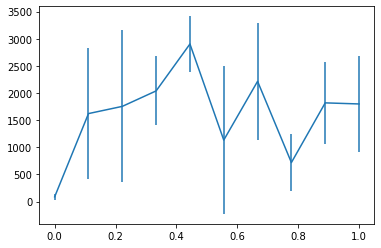

In [765]:
yerr = c_best_std
plt.errorbar(np.linspace(0.0001, 1, 10), c_best_money, yerr=yerr)

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

Каждый раз по новому(
Видимо, порог не так сильно влияет на результат и выигрывает вероятность оплаты

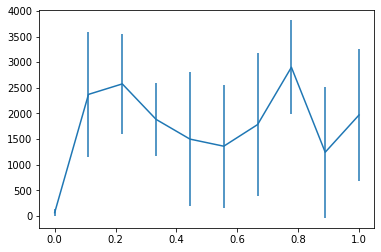

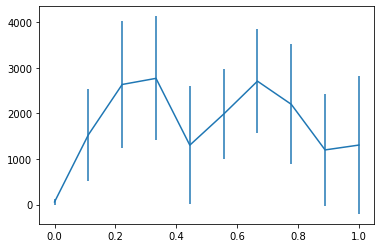

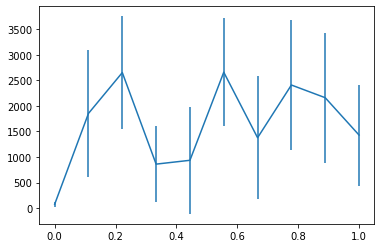

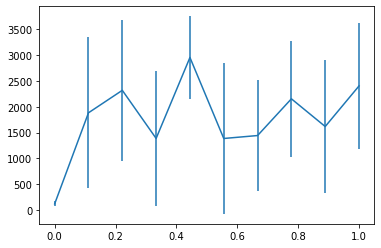

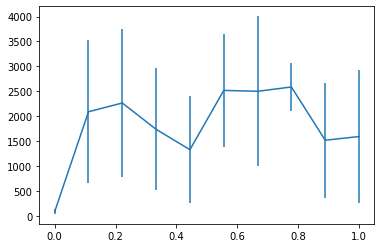

CPU times: user 6min 23s, sys: 19.3 s, total: 6min 42s
Wall time: 3min 39s


In [766]:
%%time
kf = KFold(n_splits=5, random_state=500, shuffle=True)




for _ in range(5):
    c_best_money = []
    c_best_std = []
    c_best_score = []
    for c in np.linspace(0.0001, 1, 10):
        scores = []
        money = []
        for train_index, test_index in kf.split(x):
            X_train, X_test = x[train_index], x[test_index]
            y_train, y_test = y[train_index], y[test_index]
            lr = LogisticRegression(max_iter=100000, C=c)
            lr.fit(X_train, y_train)

            y_score = lr.predict(X_test)
            precision, recall, thresholds = precision_recall_curve(y_test, y_score)
            scores.append(auc(recall, precision))
            money.append(sum((y_score == y_test) & (y_test == 1)) * int(np.random.uniform(0, 20)))

        c_best_money.append(np.mean(money))
        c_best_std.append(np.std(money)) 
        c_best_score.append(np.mean(scores))
        
    yerr = c_best_std
    
    ax = plt.errorbar(np.linspace(0.0001, 1, 10), c_best_money, yerr=yerr)
    plt.show()
    

__Задание 12 (1 балл).__ Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ корее всего recall, потому что мы можем себе позволтиь если что ошибиться при звонке, главное набрать как можно больше клиентов



Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки порога бинаризации этих вероятностей мы сможем получить какой-то выигрыш? Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [767]:
%%time
kf = KFold(n_splits=5, random_state=500, shuffle=True)

t_money = []
t_std = []
t_score = []
t_precision = []
t_recall = []
for t in tqdm(np.linspace(0, 1, 100)):
    scores = []
    money = []
    precision = []
    recall = []
    for train_index, test_index in kf.split(x):
        
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        lr = LogisticRegression(max_iter=1000000)
        lr.fit(X_train, y_train)
        y_score = lr.predict(X_test)
        
        probability_one = pd.DataFrame(lr.predict_proba(X_test))[1]
        y_score_new = np.where(probability_one < t, 0, y_score)
        
        precision, recall, thresholds = precision_recall_curve(y_test, y_score_new)
#         print('------')
#         print(metrics.precision_score(y_test, y_score_new))
#         print('------')
# #         print(precision, recall, thresholds)
#         print(metrics.recall_score(y_test, y_score_new))
#         print('------')
        t_precision.append(precision)
        t_recall.append(recall)
        
        scores.append(auc(recall, precision))
        money.append((sum((y_score_new == y_test) & (y_test == 1)) * int(np.random.uniform(0, 20))))

    t_money.append(np.mean(money))
    t_std.append(np.std(money)) 
    t_score.append(np.mean(scores)) 
    t_precision.append(np.mean(precision))
    t_recall.append(np.mean(recall))

100%|█████████████████████████████████████████| 100/100 [12:26<00:00,  7.46s/it]

CPU times: user 18min 20s, sys: 56.1 s, total: 19min 16s
Wall time: 12min 26s


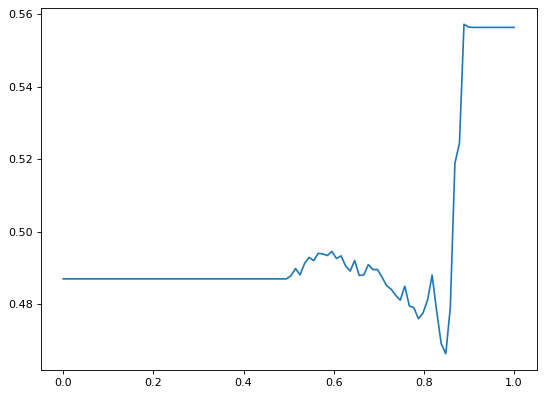

In [768]:
yerr = t_std
plt.figure(figsize=(8, 6), dpi=80)
ax = plt.errorbar(np.linspace(0, 1, 100), t_score)
plt.show()

In [769]:
np.linspace(0, 1, 100)[np.argmax(t_score)]

0.888888888888889

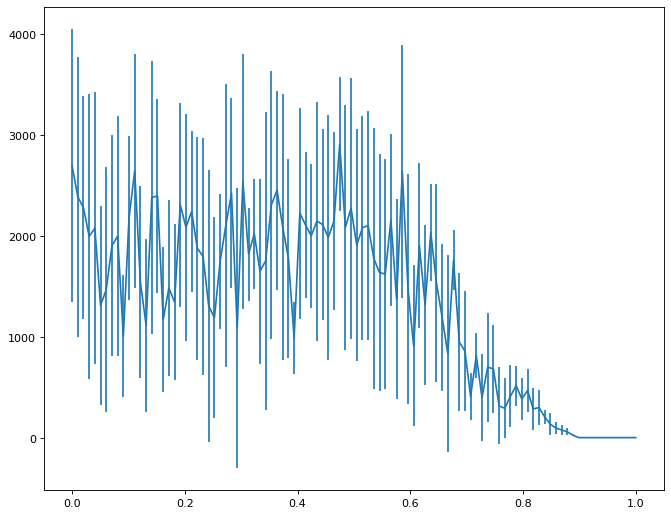

In [770]:
yerr = t_std
plt.figure(figsize=(10, 8), dpi=80)
ax = plt.errorbar(np.linspace(0, 1, 100), t_money, yerr)
plt.show()

In [771]:
np.linspace(0, 1, 100)[np.argmax(t_money)]

0.4747474747474748

In [772]:
t_money[np.argmax(t_money)] # неплохо!

2907.6

Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог. 


__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

__Ответ__: Да, как и было сказано ранне - для нас важнее recall, поэтому чем больше порог, тем меньше единичек будут попадать
До какого-то момента это некритично и значение порога может меняться из-за вероятностей, а потом резко идет на спад

In [778]:
import warnings
warnings.filterwarnings("ignore")

100%|█████████████████████████████████████████| 100/100 [10:06<00:00,  6.06s/it]


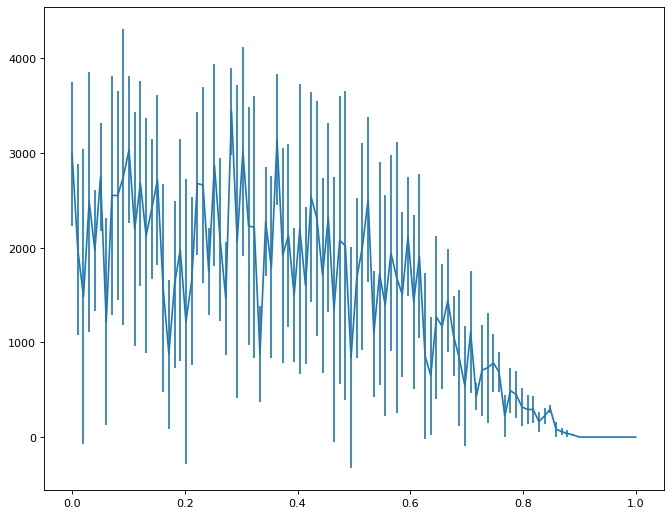

  0%|                                                   | 0/100 [00:00<?, ?it/s]

Лучший порог: 0.2828282828282829
Заработаем: 3438.2
PR: 0.6573002199413489
Recall: 0.22983381409204187


100%|█████████████████████████████████████████| 100/100 [09:38<00:00,  5.78s/it]


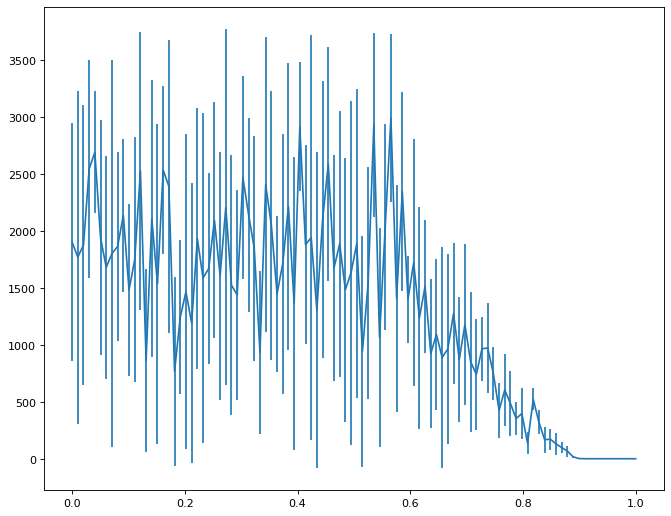

  0%|                                                   | 0/100 [00:00<?, ?it/s]

Лучший порог: 0.5656565656565657
Заработаем: 2994.0
PR: 0.7006723316524114
Recall: 0.19682973527832778


100%|█████████████████████████████████████████| 100/100 [09:34<00:00,  5.74s/it]


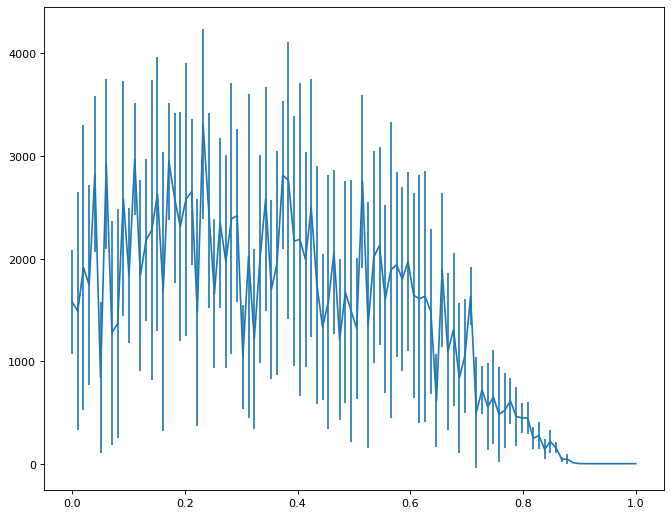

  0%|                                                   | 0/100 [00:00<?, ?it/s]

Лучший порог: 0.23232323232323235
Заработаем: 3310.6
PR: 0.6573002199413489
Recall: 0.22983381409204187


100%|█████████████████████████████████████████| 100/100 [09:46<00:00,  5.87s/it]


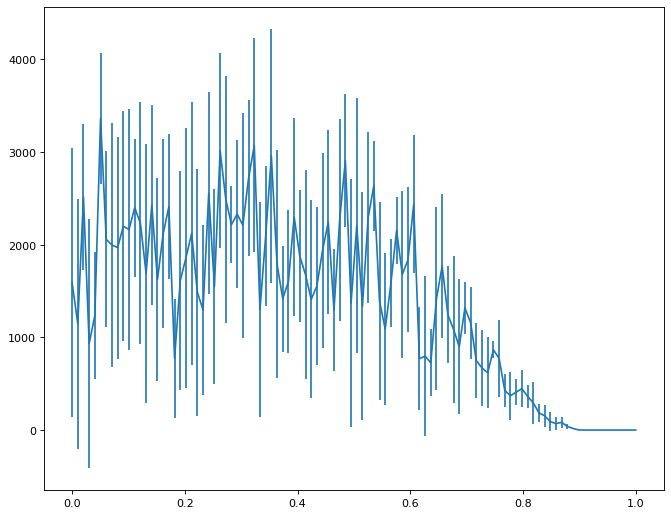

  0%|                                                   | 0/100 [00:00<?, ?it/s]

Лучший порог: 0.05050505050505051
Заработаем: 3357.8
PR: 0.6573002199413489
Recall: 0.22983381409204187


100%|█████████████████████████████████████████| 100/100 [10:06<00:00,  6.06s/it]


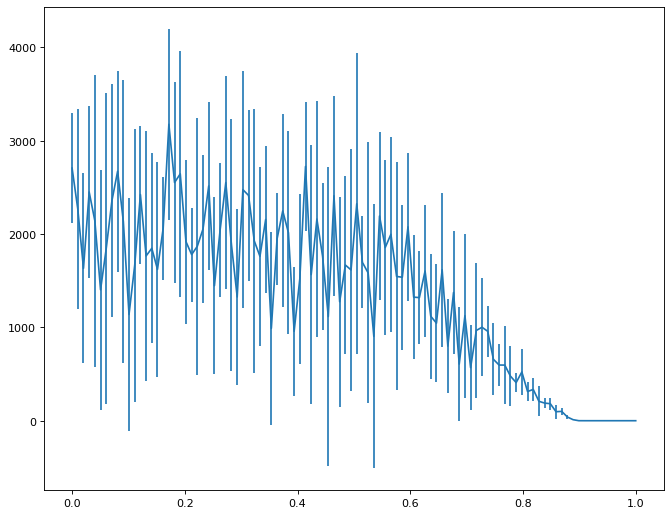

Лучший порог: 0.17171717171717174
Заработаем: 3175.8
PR: 0.6573002199413489
Recall: 0.22983381409204187
CPU times: user 1h 26min 43s, sys: 4min 12s, total: 1h 30min 56s
Wall time: 49min 12s


In [779]:
%%time
kf = KFold(n_splits=5, random_state=500, shuffle=True)

for _ in range(5):
    t_money = []
    t_std = []
    t_score = []
    t_precision = []
    t_recall = []
    for t in tqdm(np.linspace(0, 1, 100)):
        scores = []
        money = []
        precision_ = []
        recall_ = []
        for train_index, test_index in kf.split(x):

            X_train, X_test = x[train_index], x[test_index]
            y_train, y_test = y[train_index], y[test_index]

            lr = LogisticRegression(max_iter=100000)
            lr.fit(X_train, y_train)
            y_score = lr.predict(X_test)

            probability_one = pd.DataFrame(lr.predict_proba(X_test))[1]
            y_score_new = np.where(probability_one < t, 0, y_score)

            precision, recall, thresholds = precision_recall_curve(y_test, y_score_new)
            precision_.append(metrics.precision_score(y_test, y_score_new))
            recall_.append(metrics.recall_score(y_test, y_score_new))
            scores.append(auc(recall, precision))
            money.append((sum((y_score_new == y_test) & (y_test == 1)) * int(np.random.uniform(0, 20))))

        t_money.append(np.mean(money))
        t_std.append(np.std(money)) 
        t_score.append(np.mean(scores))
        t_precision.append(np.mean(precision_))
        t_recall.append(np.mean(recall_))
    
    yerr = t_std
    plt.figure(figsize=(10, 8), dpi=80)
    ax = plt.errorbar(np.linspace(0, 1, 100), t_money, yerr)
    plt.show()
    
    print(f'Лучший порог: {np.linspace(0, 1, 100)[np.argmax(t_money)]}')
    print(f'Заработаем: {t_money[np.argmax(t_money)]}')
    print(f'PR: {t_precision[np.argmax(t_money)]}')
    print(f'Recall: {t_recall[np.argmax(t_money)]}')
    

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [781]:
# для всех случаев порог меньше 0.5, иногда значительно меньше, иногда нет - в зависимости от "удачи"
# возьмем средний порог
(0.28 + 0.57 + 0.23 + 0.05 + 0.17) / 5

0.26

In [785]:
t_precision = []
t_recall = []
t_std = []

for train_index, test_index in kf.split(x):

    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

    lr = LogisticRegression(max_iter=100000)
    lr.fit(X_train, y_train)
    y_score = lr.predict(X_test)

    probability_one = pd.DataFrame(lr.predict_proba(X_test))[1]
    y_score_new = np.where(probability_one < 0.26, 0, y_score)

    precision, recall, thresholds = precision_recall_curve(y_test, y_score_new)
    scores.append(auc(recall, precision))
    money.append((sum((y_score_new == y_test) & (y_test == 1)) * int(np.random.uniform(0, 20))))
    
    t_std.append(np.std(money))

   # print(recall)
    t_precision.append(metrics.precision_score(y_test, y_score))
    t_recall.append(metrics.recall_score(y_test, y_score))

print(f'recall:{np.mean(t_recall)}, precision:{np.mean(t_precision)}, t_std:{np.mean(t_std)}')

recall:0.22983381409204187, precision:0.6573002199413489, t_std:1074.3179071379961


Как вы, вероятно, уже поняли, ваша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом - выберите только те пороги, на которых достигается необходимый recall, затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат и посчитайте площадь под отсеченной кривой. 

In [777]:
# к сожалению, модель не добила до 0.5, поэтому эту часть задания я не смогла доделать(


__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ бутеры с авокадо и семгой

__Социализационный бонус (0.1 балл).__
Введены новые ограничения, занятия теперь дистанционные. Но это не значит, что не надо общаться с друзьями! Созвонитесь в зуме (или любым другим способом) хотя бы с двумя студентами курса МО-1 этого года, приложите скриншот созвона с включенными камерами и напишите очень кратко, на какие темы были беседы.

__Ответ:__

Мы обсуждали участие в новом хакатоне :)

In [ ]:
from IPython.display import Image
Image('hw_4.jpg')